In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor

from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime

### Load Office Data File

In [3]:
df = pd.read_csv('Office_Data.csv', parse_dates=True, index_col='timestamp')

In [4]:
df

,Meter_Data
timestamp,
2015-01-01 00:00:00,136.824997
2015-01-01 01:00:00,144.025002
2015-01-01 02:00:00,144.875000
2015-01-01 03:00:00,142.375000
2015-01-01 04:00:00,148.199997
...,...
2015-12-31 19:00:00,137.749996
2015-12-31 20:00:00,141.424999
2015-12-31 21:00:00,135.174995


<AxesSubplot:xlabel='timestamp'>

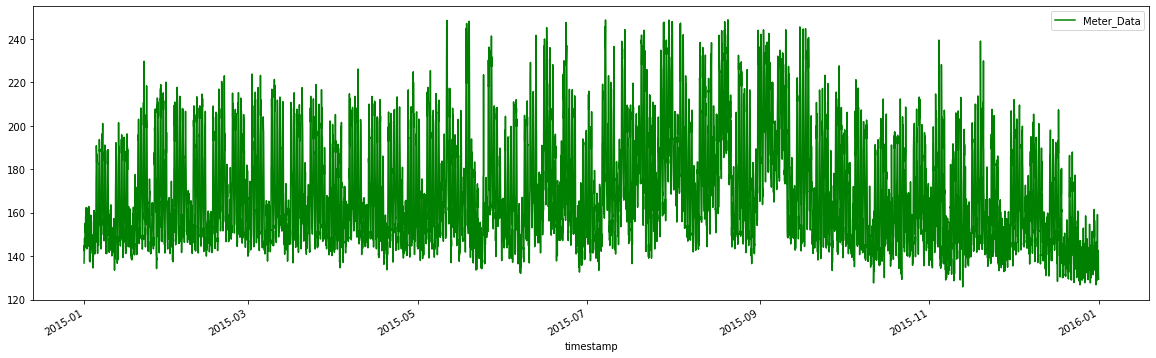

In [5]:
df.plot(figsize=(20,6),color = 'green')

### Load Weather Data file

In [6]:
weather_data = pd.read_csv("weather2.csv", index_col='timestamp', parse_dates=True)

In [7]:
weather_data.head()

,Conditions,DateUTC<br />,Dew PointC,Events,Gust SpeedKm/h,Humidity,Precipitationmm,Sea Level PressurehPa,TemperatureC,TimeEDT,TimeEST,VisibilityKm,Wind Direction,Wind SpeedKm/h,WindDirDegrees,timestamp.1
timestamp,,,,,,,,,,,,,,,,
2015-01-01 00:56:00,Overcast,2015-01-01 05:56:00<br />,-15.0,NaN,-,54.0,NaN,1017.4,-7.2,NaN,12:56 AM,16.1,SW,18.5,230,2015-01-01 00:56:00
2015-01-01 01:56:00,Overcast,2015-01-01 06:56:00<br />,-14.4,NaN,-,55.0,NaN,1017.2,-6.6,NaN,1:56 AM,16.1,WSW,14.8,240,2015-01-01 01:56:00
2015-01-01 02:56:00,Overcast,2015-01-01 07:56:00<br />,-14.4,NaN,-,55.0,NaN,1016.9,-6.6,NaN,2:56 AM,16.1,SW,14.8,220,2015-01-01 02:56:00
2015-01-01 03:56:00,Overcast,2015-01-01 08:56:00<br />,-14.4,NaN,-,55.0,NaN,1017.2,-6.6,NaN,3:56 AM,16.1,SW,18.5,220,2015-01-01 03:56:00
2015-01-01 04:56:00,Overcast,2015-01-01 09:56:00<br />,-14.4,NaN,-,55.0,NaN,1017.2,-6.6,NaN,4:56 AM,16.1,SSW,14.8,210,2015-01-01 04:56:00


<AxesSubplot:xlabel='timestamp'>

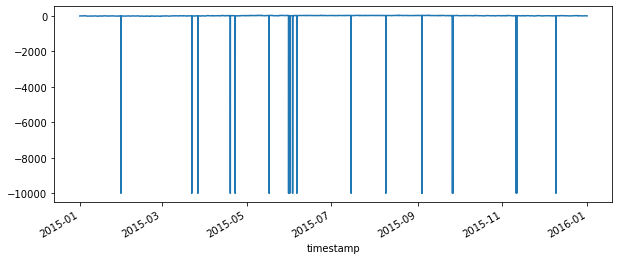

In [8]:
weather_data["TemperatureC"].plot(figsize=(10,4))

### Find and remove outliers

In [9]:
weather_hourly = weather_data.resample("H").mean()

In [10]:
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]

In [11]:
weather_hourly_nooutlier.head(10)

,Dew PointC,Humidity,Precipitationmm,Sea Level PressurehPa,TemperatureC,VisibilityKm,WindDirDegrees
timestamp,,,,,,,
2015-01-01 00:00:00,-15.0,54.0,NaN,1017.4,-7.20,16.1,230.0
2015-01-01 01:00:00,-14.4,55.0,NaN,1017.2,-6.60,16.1,240.0
2015-01-01 02:00:00,-14.4,55.0,NaN,1016.9,-6.60,16.1,220.0
2015-01-01 03:00:00,-14.4,55.0,NaN,1017.2,-6.60,16.1,220.0
2015-01-01 04:00:00,-14.4,55.0,NaN,1017.2,-6.60,16.1,210.0
2015-01-01 05:00:00,-13.8,57.0,NaN,1017.4,-6.60,16.1,230.0
2015-01-01 06:00:00,-13.9,56.5,NaN,1016.3,-6.55,16.1,225.0
2015-01-01 07:00:00,-12.7,60.0,NaN,1017.1,-6.10,16.1,230.0
2015-01-01 08:00:00,-12.7,55.0,NaN,1017.0,-5.00,16.1,220.0


<AxesSubplot:xlabel='timestamp'>

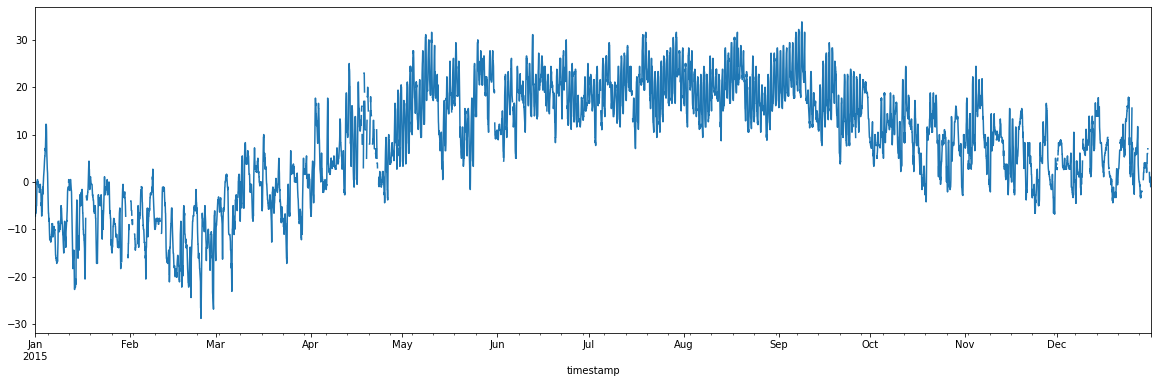

In [12]:
## SANITY CHECk

weather_hourly_nooutlier["TemperatureC"].plot(figsize=(20,6))

### Filling Gaps in Data

#### Fill the gap left by filtering the outliers

In [13]:
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')

In [14]:
weather_hourly_nooutlier_nogaps.head()

,Dew PointC,Humidity,Precipitationmm,Sea Level PressurehPa,TemperatureC,VisibilityKm,WindDirDegrees
timestamp,,,,,,,
2015-01-01 00:00:00,-15.0,54.0,NaN,1017.4,-7.2,16.1,230.0
2015-01-01 01:00:00,-14.4,55.0,NaN,1017.2,-6.6,16.1,240.0
2015-01-01 02:00:00,-14.4,55.0,NaN,1016.9,-6.6,16.1,220.0
2015-01-01 03:00:00,-14.4,55.0,NaN,1017.2,-6.6,16.1,220.0
2015-01-01 04:00:00,-14.4,55.0,NaN,1017.2,-6.6,16.1,210.0


### Merge Electricity and Temerature Data

In [15]:
comparison = pd.merge(weather_hourly_nooutlier_nogaps['TemperatureC'], df['Meter_Data'], left_index=True, right_index=True, how='outer')

In [16]:
comparison.head()

,TemperatureC,Meter_Data
timestamp,,
2015-01-01 00:00:00,-7.2,136.824997
2015-01-01 01:00:00,-6.6,144.025002
2015-01-01 02:00:00,-6.6,144.875000
2015-01-01 03:00:00,-6.6,142.375000
2015-01-01 04:00:00,-6.6,148.199997


array([<AxesSubplot:xlabel='timestamp'>, <AxesSubplot:xlabel='timestamp'>],
      dtype=object)

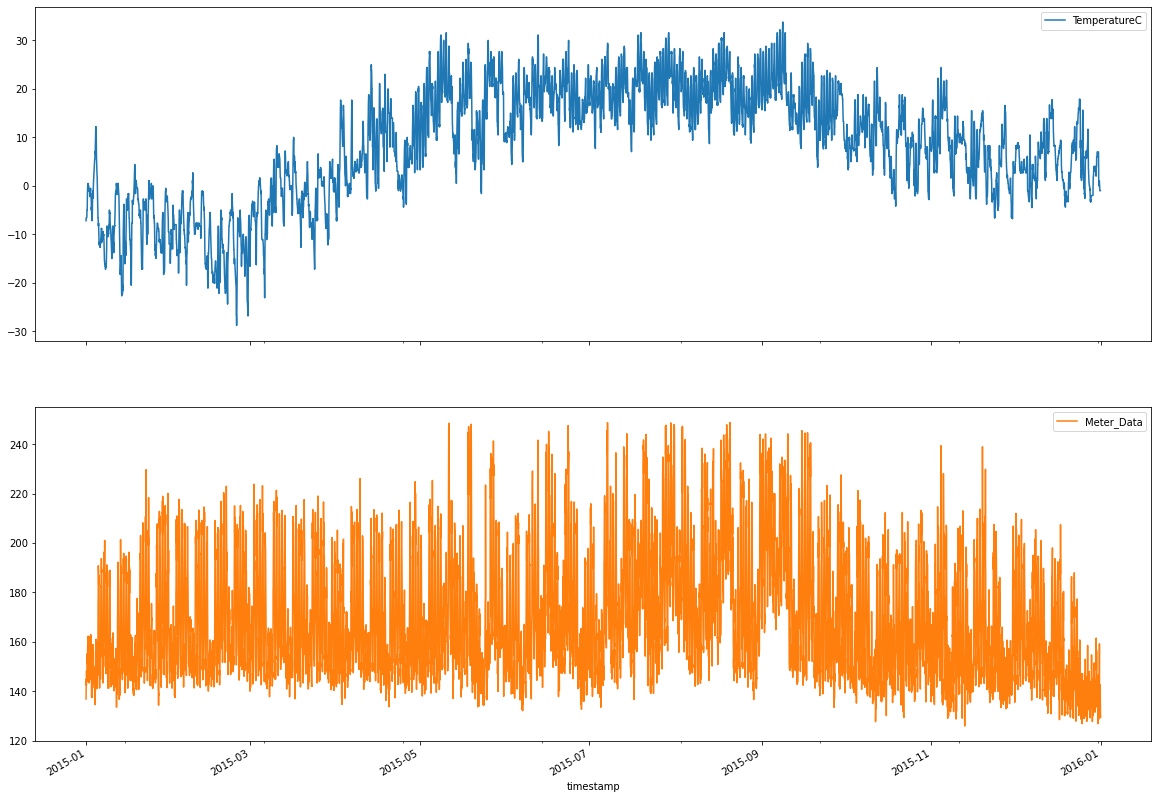

In [17]:
comparison.plot(figsize=(20,15), subplots=True)

### Analyze weather influence on energy consumption

<AxesSubplot:xlabel='TemperatureC', ylabel='Meter_Data'>

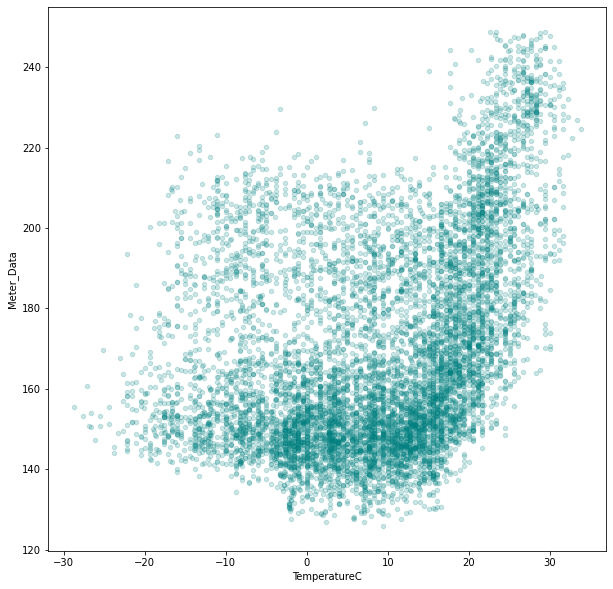

In [18]:
comparison.plot(kind='scatter', x='TemperatureC', y='Meter_Data', figsize=(10,10), alpha = 0.2, color = 'teal')

<AxesSubplot:xlabel='TemperatureC', ylabel='Meter_Data'>

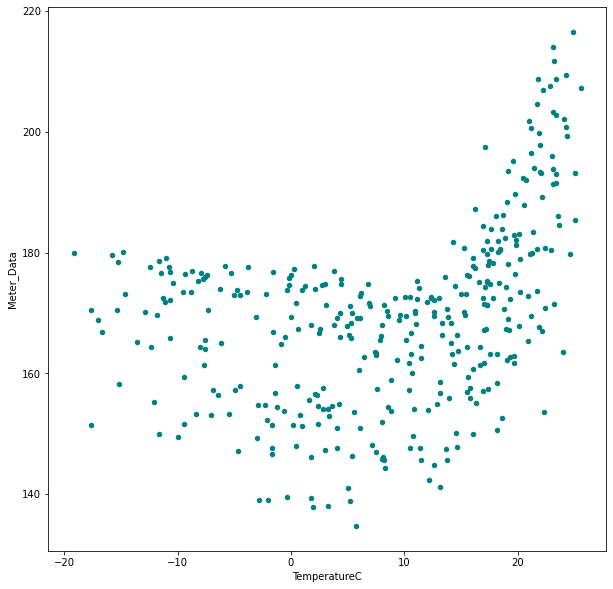

In [19]:
comparison.resample("D").mean().plot(kind='scatter', x='TemperatureC', y='Meter_Data', color = 'teal', figsize=(10,10))

## Using Seaborn Visualization to show conclusions

In [20]:
comparison.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2015-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TemperatureC  8759 non-null   float64
 1   Meter_Data    8760 non-null   float64
dtypes: float64(2)
memory usage: 205.3 KB


#### Using 14 degC as baseline

In [21]:
comparison[comparison.TemperatureC > 14].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3269 entries, 2015-04-02 12:00:00 to 2015-12-25 14:00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TemperatureC  3269 non-null   float64
 1   Meter_Data    3269 non-null   float64
dtypes: float64(2)
memory usage: 76.6 KB


In [22]:
def make_color_division(x):
  if x < 14:
    return "Heating"
  else:
    return "Cooling"

In [23]:
comparison = comparison.resample("D").mean()

In [24]:
comparison['heating_vs_cooling'] = comparison.TemperatureC.apply(lambda x: make_color_division(x))

In [25]:
comparison.head()

,TemperatureC,Meter_Data,heating_vs_cooling
timestamp,,,
2015-01-01,-3.027083,149.362500,Heating
2015-01-02,-1.704167,151.513542,Heating
2015-01-03,-1.707639,147.725000,Heating
2015-01-04,7.135417,148.089584,Heating
2015-01-05,-7.598958,163.968750,Heating


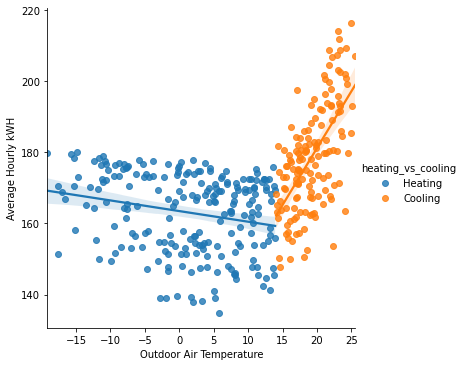

In [26]:
g = sns.lmplot(x="TemperatureC", y="Meter_Data", hue="heating_vs_cooling",
               truncate=True, data=comparison)

g.set_axis_labels("Outdoor Air Temperature", "Average Hourly kWH")

## Using Unsupervised Learning to Cluster Daily Load Profiles

In [27]:
df['Date'] = df.index.map(lambda t: t.date())
df['Time'] = df.index.map(lambda t: t.time())

In [28]:
df.head()

,Meter_Data,Date,Time
timestamp,,,
2015-01-01 00:00:00,136.824997,2015-01-01,00:00:00
2015-01-01 01:00:00,144.025002,2015-01-01,01:00:00
2015-01-01 02:00:00,144.875000,2015-01-01,02:00:00
2015-01-01 03:00:00,142.375000,2015-01-01,03:00:00
2015-01-01 04:00:00,148.199997,2015-01-01,04:00:00


In [29]:
df_pivot = pd.pivot_table(df, values='Meter_Data', index='Date', columns='Time')


In [30]:
df_pivot.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,136.824997,144.025002,144.875000,142.375000,148.199997,147.750000,143.800003,144.725006,154.550003,155.125000,...,158.225006,151.575005,162.224998,155.149994,148.025002,146.899994,151.949997,149.599998,148.325005,144.224998
2015-01-02,162.224995,143.325001,148.575005,145.400002,147.024994,146.924995,146.799995,152.175003,153.125000,161.150002,...,155.300003,152.099998,158.125000,162.849998,148.625000,148.075005,144.549995,151.000000,148.599998,144.550003
2015-01-03,137.625008,142.050003,149.375000,137.349998,145.199997,143.500000,148.775002,144.049999,148.350006,158.849998,...,158.624992,155.724998,155.825005,145.224998,146.700005,147.224998,144.825005,146.500000,143.000000,145.524994
2015-01-04,141.224998,146.325005,144.500000,138.775002,144.750000,139.425003,134.574997,149.824997,139.600002,149.775002,...,154.799995,160.974998,156.650002,160.250000,153.875000,153.700005,144.574997,141.025002,144.400002,142.575005
2015-01-05,153.674995,141.625004,148.625000,146.375000,148.174995,148.724998,146.575005,163.750000,175.275002,178.175003,...,185.000000,186.875000,183.474998,172.074997,154.950005,156.549995,151.325005,141.250004,153.224998,148.400002


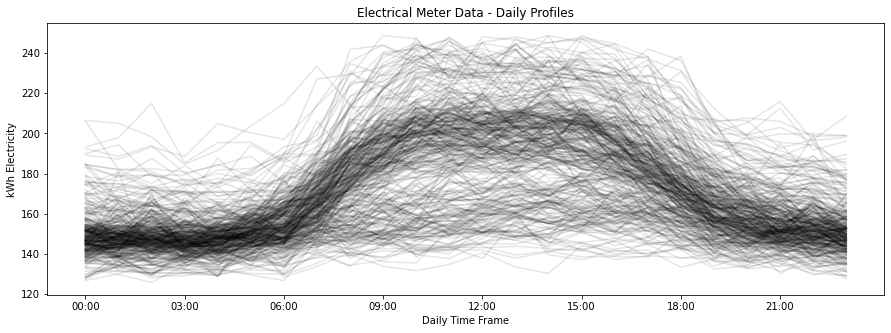

In [31]:
df_pivot.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=np.arange(0, 86400, 10800))

plt.title("Electrical Meter Data - Daily Profiles")
plt.xlabel("Daily Time Frame")
plt.ylabel("kWh Electricity");

### Divide Weekdays and Weekends

In [32]:
df['Weekday'] = df.index.map(lambda t: t.date().weekday())

In [33]:
df.head()

,Meter_Data,Date,Time,Weekday
timestamp,,,,
2015-01-01 00:00:00,136.824997,2015-01-01,00:00:00,3
2015-01-01 01:00:00,144.025002,2015-01-01,01:00:00,3
2015-01-01 02:00:00,144.875000,2015-01-01,02:00:00,3
2015-01-01 03:00:00,142.375000,2015-01-01,03:00:00,3
2015-01-01 04:00:00,148.199997,2015-01-01,04:00:00,3


In [34]:
df_pivot_weekday = pd.pivot_table(df[(df.Weekday < 5)], values='Meter_Data', index='Date', columns='Time')


#### Plot Weekday

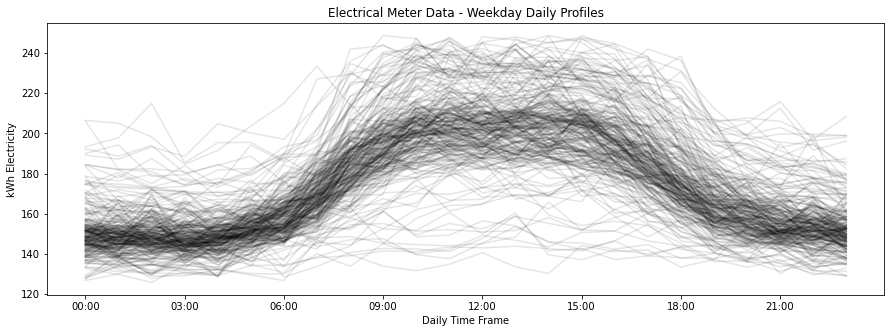

In [35]:
df_pivot_weekday.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=np.arange(0, 86400, 10800))
plt.title("Electrical Meter Data - Weekday Daily Profiles")
plt.xlabel("Daily Time Frame")
plt.ylabel("kWh Electricity");

#### Plot weekend

In [36]:
df_pivot_weekend = pd.pivot_table(df[(df.Weekday > 5)], values='Meter_Data', index='Date', columns='Time')


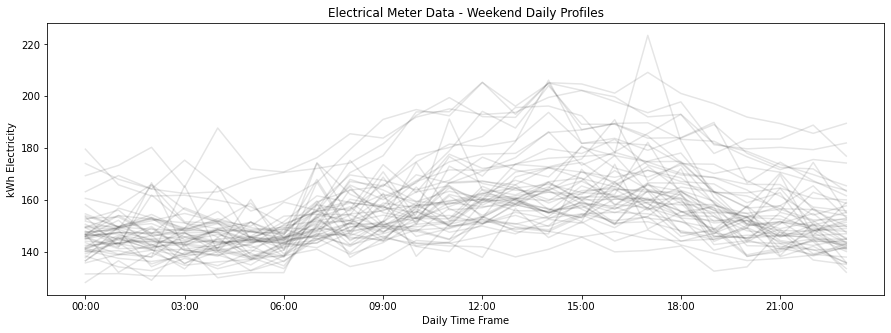

In [37]:
df_pivot_weekend.T.plot(legend=False, figsize=(15,5), color='k', alpha=0.1, xticks=np.arange(0, 86400, 10800))

plt.title("Electrical Meter Data - Weekend Daily Profiles")
plt.xlabel("Daily Time Frame")
plt.ylabel("kWh Electricity");

### Conslusion:
Weekends have a lower standard level of consumption with only bits of consumption during daytime hours

## K-Means Clustering

In [38]:
df = pd.read_csv('Office_Data.csv', parse_dates=True, index_col='timestamp')

In [39]:
df_norm = (df - df.mean()) / (df.max() - df.min()) 

df['Time'] = df.index.map(lambda t: t.time())
df['Date'] = df.index.map(lambda t: t.date())
df_norm['Time'] = df_norm.index.map(lambda t: t.time())
df_norm['Date'] = df_norm.index.map(lambda t: t.date())

In [40]:
df.head()

,Meter_Data,Time,Date
timestamp,,,
2015-01-01 00:00:00,136.824997,00:00:00,2015-01-01
2015-01-01 01:00:00,144.025002,01:00:00,2015-01-01
2015-01-01 02:00:00,144.875000,02:00:00,2015-01-01
2015-01-01 03:00:00,142.375000,03:00:00,2015-01-01
2015-01-01 04:00:00,148.199997,04:00:00,2015-01-01


### Normalize the dailyblocks and pivot

In [41]:
dailyblocks = pd.pivot_table(df, values='Meter_Data', index='Date', columns='Time', aggfunc='mean')
dailyblocks_norm = pd.pivot_table(df_norm, values='Meter_Data', index='Date', columns='Time', aggfunc='mean')

In [42]:
dailyblocks_norm.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,-0.264810,-0.206214,-0.199297,-0.219642,-0.172237,-0.175899,-0.208045,-0.200517,-0.120558,-0.115878,...,-0.090649,-0.144770,-0.058096,-0.115675,-0.173661,-0.182816,-0.141718,-0.160843,-0.171219,-0.204586
2015-01-02,-0.058096,-0.211911,-0.169185,-0.195024,-0.181799,-0.182613,-0.183630,-0.139887,-0.132155,-0.066845,...,-0.114454,-0.140497,-0.091463,-0.053010,-0.168778,-0.173254,-0.201942,-0.149449,-0.168981,-0.201941
2015-01-03,-0.258300,-0.222287,-0.162674,-0.260538,-0.196652,-0.210487,-0.167557,-0.206011,-0.171016,-0.085563,...,-0.087394,-0.110995,-0.110182,-0.196448,-0.184444,-0.180171,-0.199703,-0.186072,-0.214556,-0.194007
2015-01-04,-0.229002,-0.187496,-0.202348,-0.248940,-0.200314,-0.243651,-0.283122,-0.159012,-0.242226,-0.159419,...,-0.118523,-0.068269,-0.103467,-0.074169,-0.126051,-0.127476,-0.201738,-0.230629,-0.203162,-0.218015
2015-01-05,-0.127679,-0.225746,-0.168778,-0.187089,-0.172440,-0.167964,-0.185461,-0.045685,0.048109,0.071711,...,0.127255,0.142514,0.114844,0.022067,-0.117303,-0.104281,-0.146804,-0.228798,-0.131341,-0.170609


### The Clustering Model

In [43]:
dailyblocksmatrix_norm = np.matrix(dailyblocks_norm.dropna())
centers, _ = kmeans(dailyblocksmatrix_norm, 4, iter=10000)
cluster, _ = vq(dailyblocksmatrix_norm, centers)

In [44]:
clusterdf = pd.DataFrame(cluster, columns=['ClusterNo'])

In [45]:
dailyclusters = pd.concat([dailyblocks.dropna().reset_index(), clusterdf], axis=1) 

### Dataframe shows cluster number assigned by K-Means Process

In [46]:
dailyclusters.head()

,Date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,ClusterNo
0,2015-01-01,136.824997,144.025002,144.875000,142.375000,148.199997,147.750000,143.800003,144.725006,154.550003,...,151.575005,162.224998,155.149994,148.025002,146.899994,151.949997,149.599998,148.325005,144.224998,1
1,2015-01-02,162.224995,143.325001,148.575005,145.400002,147.024994,146.924995,146.799995,152.175003,153.125000,...,152.099998,158.125000,162.849998,148.625000,148.075005,144.549995,151.000000,148.599998,144.550003,1
2,2015-01-03,137.625008,142.050003,149.375000,137.349998,145.199997,143.500000,148.775002,144.049999,148.350006,...,155.724998,155.825005,145.224998,146.700005,147.224998,144.825005,146.500000,143.000000,145.524994,1
3,2015-01-04,141.224998,146.325005,144.500000,138.775002,144.750000,139.425003,134.574997,149.824997,139.600002,...,160.974998,156.650002,160.250000,153.875000,153.700005,144.574997,141.025002,144.400002,142.575005,1
4,2015-01-05,153.674995,141.625004,148.625000,146.375000,148.174995,148.724998,146.575005,163.750000,175.275002,...,186.875000,183.474998,172.074997,154.950005,156.549995,151.325005,141.250004,153.224998,148.400002,0


In [47]:
## GROUPBY EACH CLUSTER

x = dailyclusters.groupby('ClusterNo').mean().sum(axis=1).sort_values()
x = pd.DataFrame(x.reset_index())
x['ClusterNo2'] = x.index
x = x.set_index('ClusterNo')
x = x.drop([0], axis=1)
dailyclusters = dailyclusters.merge(x, how='outer', left_on='ClusterNo', right_index=True)

In [48]:
dailyclusters = dailyclusters.drop(['ClusterNo'],axis=1)
dailyclusters = dailyclusters.set_index(['ClusterNo2','Date']).T.sort_index()

In [49]:
dailyclusters.head()

ClusterNo2           0                                                  \
Date        2015-01-01  2015-01-02  2015-01-03  2015-01-04  2015-01-10   
00:00:00    136.824997  162.224995  137.625008  141.224998  145.875004   
01:00:00    144.025002  143.325001  142.050003  146.325005  141.800003   
02:00:00    144.875000  148.575005  149.375000  144.500000  147.525002   
03:00:00    142.375000  145.400002  137.349998  138.775002  144.975006   
04:00:00    148.199997  147.024994  145.199997  144.750000  148.399994   

ClusterNo2                                                              ...  \
Date        2015-01-11  2015-01-17  2015-01-18  2015-01-19  2015-01-24  ...   
00:00:00    140.125000  147.574997  141.150002  141.400002  143.800003  ...   
01:00:00    143.524998  162.824997  138.750000  140.924999  144.625000  ...   
02:00:00    144.800003  149.650002  140.600002  144.300003  142.275002  ...   
03:00:00    143.449997  148.299995  140.924999  145.949997  149.574997  ...   
04:00:00    148.599998  145.074997  138.250000  140.599998  155.625000  ...   

ClusterNo2           3                                                  \
Date        2015-09-04  2015-09-05  2015-09-07  2015-09-08  2015-09-09   
00:00:00    189.974998  183.050003  175.399994  178.524994  206.500000   
01:00:00    194.299995  178.824997  174.800003  176.400002  205.000000   
02:00:00    178.649994  179.250000  173.300003  179.674995  198.250000   
03:00:00    179.449997  176.025002  170.949997  174.525002  184.625000   
04:00:00    184.549995  179.950005  170.599991  175.400009  191.549995   

ClusterNo2                                                              
Date        2015-09-10  2015-09-15  2015-09-16  2015-09-17  2015-09-18  
00:00:00    174.500000  149.774994  146.450005  151.849998  156.900002  
01:00:00    180.549995  158.449997  154.449997  146.674995  155.875000  
02:00:00    173.300003  152.425003  152.525002  162.424999  153.125008  
03:00:00    177.375000  154.800003  148.074997  149.299995  155.199997  
04:00:00    174.800003  156.400002  145.699997  144.450001  152.225006  

[5 rows x 364 columns]

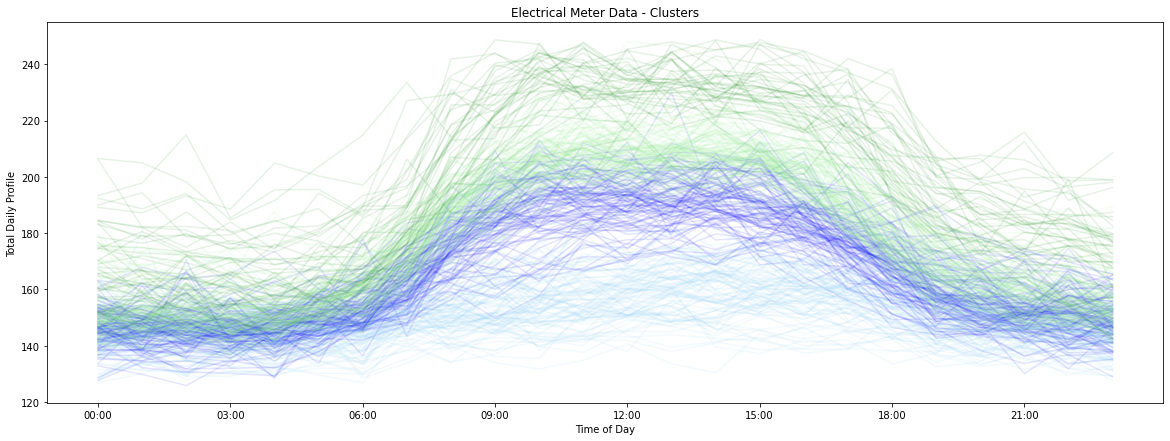

In [50]:
clusterlist = list(dailyclusters.columns.get_level_values(0).unique())
matplotlib.rcParams['figure.figsize'] = 20, 7

styles2 = ['LightSkyBlue', 'b','LightGreen', 'g','LightCoral','r','SandyBrown','Orange','Plum','Purple','Gold','b']
fig, ax = plt.subplots()
for col, style in zip(clusterlist, styles2):
    dailyclusters[col].plot(ax=ax, legend=False, style=style, alpha=0.1, xticks=np.arange(0, 86400, 10800))

plt.title("Electrical Meter Data - Clusters")
ax.set_ylabel('Total Daily Profile')
ax.set_xlabel('Time of Day');

### Aggregate Visualization of Clusters

In [51]:
def timestampcombine(date,time):
    pydatetime = datetime.combine(date, time)
    return pydatetime

In [52]:
def ClusterUnstacker(df):
    df = df.unstack().reset_index()
    df['timestampstring'] = pd.to_datetime(df.Date.astype("str") + " " + df.level_2.astype("str"))
    #pd.to_datetime(df.Date  df.level_2) #map(timestampcombine, )
    df = df.dropna()
    return df

In [53]:
dailyclusters.unstack().reset_index().head()

,ClusterNo2,Date,level_2,0
0,0,2015-01-01,00:00:00,136.824997
1,0,2015-01-01,01:00:00,144.025002
2,0,2015-01-01,02:00:00,144.875000
3,0,2015-01-01,03:00:00,142.375000
4,0,2015-01-01,04:00:00,148.199997


In [54]:
dfclusterunstacked = ClusterUnstacker(dailyclusters)
dfclusterunstackedpivoted = pd.pivot_table(dfclusterunstacked, values=0, index='timestampstring', columns='ClusterNo2')

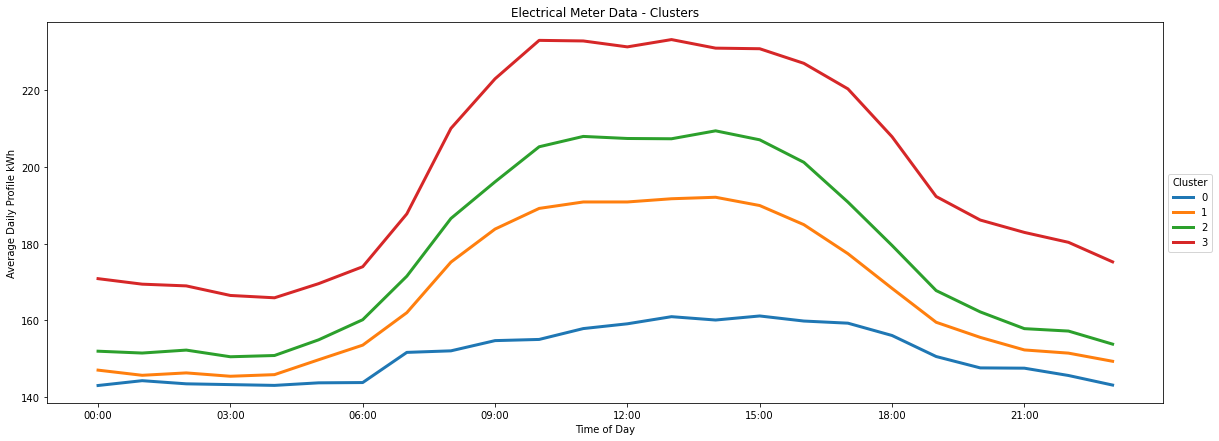

In [55]:
dfclusterunstackedpivoted['Time'] = dfclusterunstackedpivoted.index.map(lambda t: t.time())
dailyprofile = dfclusterunstackedpivoted.groupby('Time').mean().plot(figsize=(20,7),
                                                                     linewidth=3, 
                                                                     xticks=np.arange(0, 86400, 10800))
plt.title("Electrical Meter Data - Clusters")
dailyprofile.set_ylabel('Average Daily Profile kWh')
dailyprofile.set_xlabel('Time of Day')
dailyprofile.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

In [56]:
def DayvsClusterMaker(df):
    df.index = df.timestampstring
    df['Weekday'] = df.index.map(lambda t: t.date().weekday())
    df['Date'] = df.index.map(lambda t: t.date())
    df['Time'] = df.index.map(lambda t: t.time())
    DayVsCluster = df.resample('D').mean().reset_index(drop=True)
    DayVsCluster = pd.pivot_table(DayVsCluster, values=0, index='ClusterNo2', columns='Weekday', aggfunc='count')
    DayVsCluster.columns = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return DayVsCluster.T

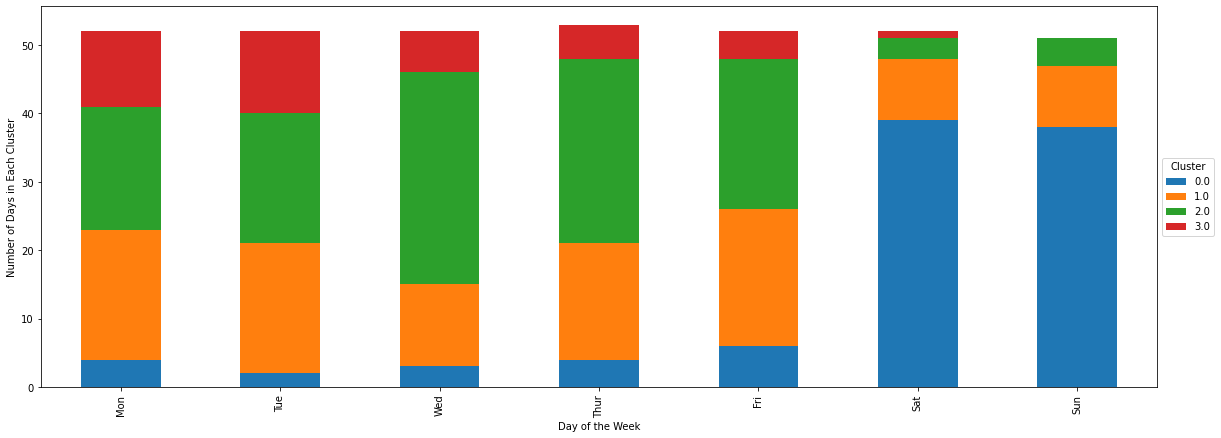

In [57]:
DayVsCluster = DayvsClusterMaker(dfclusterunstacked)
DayVsClusterplot1 = DayVsCluster.plot(figsize=(20,7),kind='bar',stacked=True)
DayVsClusterplot1.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot1.set_xlabel('Day of the Week')
DayVsClusterplot1.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Cluster')

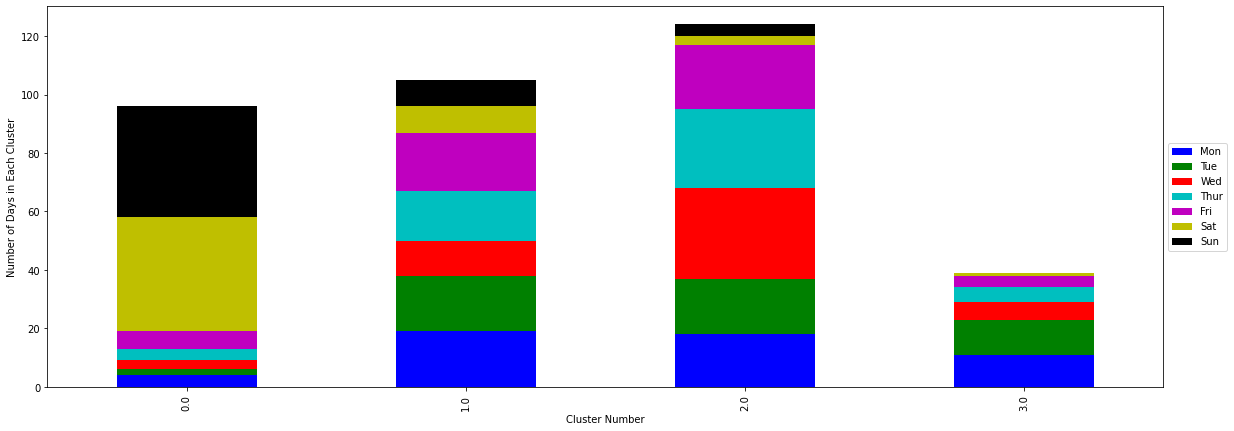

In [58]:
DayVsClusterplot2 = DayVsCluster.T.plot(figsize=(20,7),kind='bar',stacked=True, color=['b','g','r','c','m','y','k']) #, color=colors2
DayVsClusterplot2.set_ylabel('Number of Days in Each Cluster')
DayVsClusterplot2.set_xlabel('Cluster Number')
DayVsClusterplot2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Making Predictions

### Create Train and Test Datasets for Supervsed Learning

In [59]:
df_prediction_data = pd.read_csv('Office_Data.csv', parse_dates=True, index_col='timestamp')

<AxesSubplot:xlabel='timestamp'>

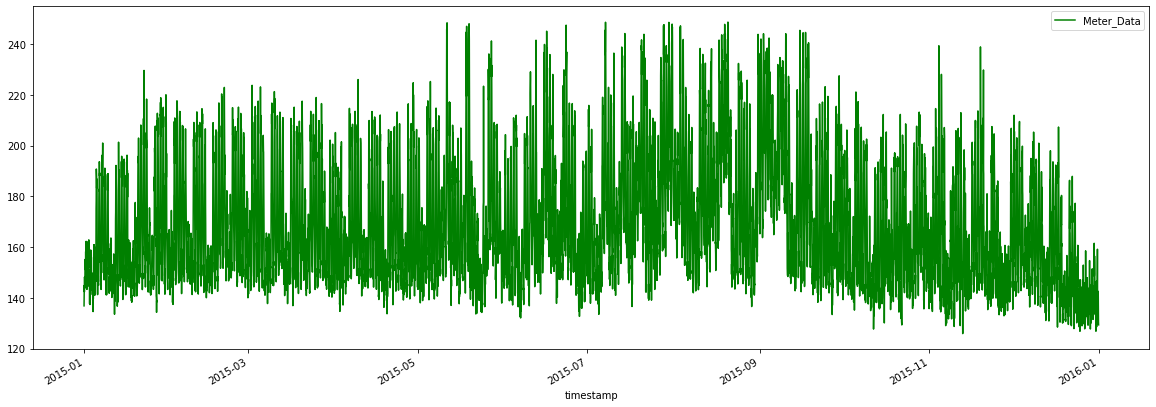

In [60]:
df_prediction_data.plot(color = "green")

In [61]:
temperature = weather_hourly_nooutlier_nogaps["TemperatureC"]

<AxesSubplot:xlabel='timestamp'>

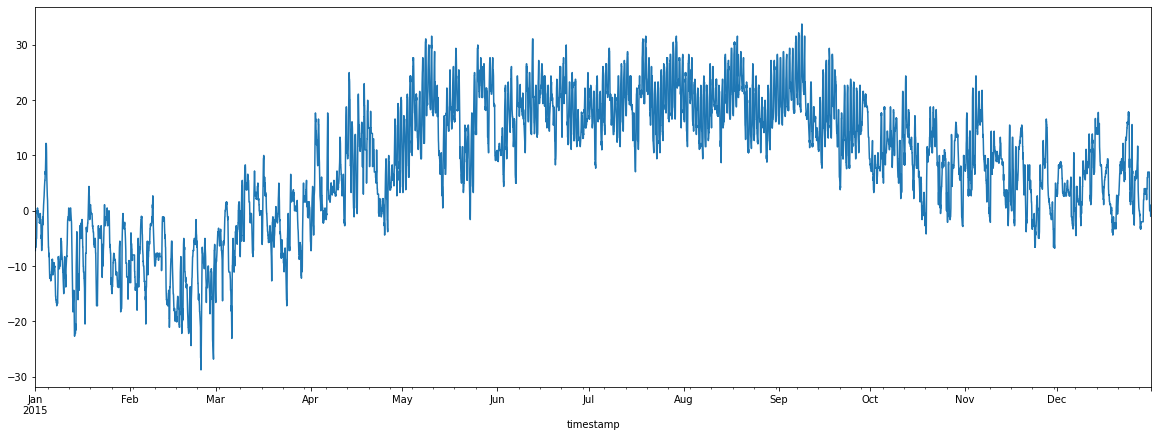

In [62]:
temperature.plot()

In [63]:
training_months = [4,5,6]
test_months = [7]

In [64]:
trainingdata = df_prediction_data[df_prediction_data.index.month.isin(training_months)]
testdata = df_prediction_data[df_prediction_data.index.month.isin(test_months)]


In [65]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2184 entries, 2015-04-01 00:00:00 to 2015-06-30 23:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Meter_Data  2184 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [66]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2015-07-01 00:00:00 to 2015-07-31 23:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Meter_Data  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


### Encoding categorical variables

In [67]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour), 
                                     pd.get_dummies(trainingdata.index.dayofweek), 
                                     pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()


In [68]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,0,1,2,3,4,5,6,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-5.5
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-6.1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-7.2
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-6.6
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-7.2


### Train a K-Neighbor Regression Model

In [69]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values));


In [70]:
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())

### Use the model to predict for TEST Period

In [71]:
predictions = model.predict(test_features)

In [72]:
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, index=testdata.index)], axis=1)

In [73]:
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [74]:
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2015-07-01 00:00:00,151.525002,171.324998
2015-07-01 01:00:00,152.575005,185.139999
2015-07-01 02:00:00,149.725006,161.014999
2015-07-01 03:00:00,151.125000,187.010001
2015-07-01 04:00:00,146.000000,163.575000


<AxesSubplot:xlabel='timestamp'>

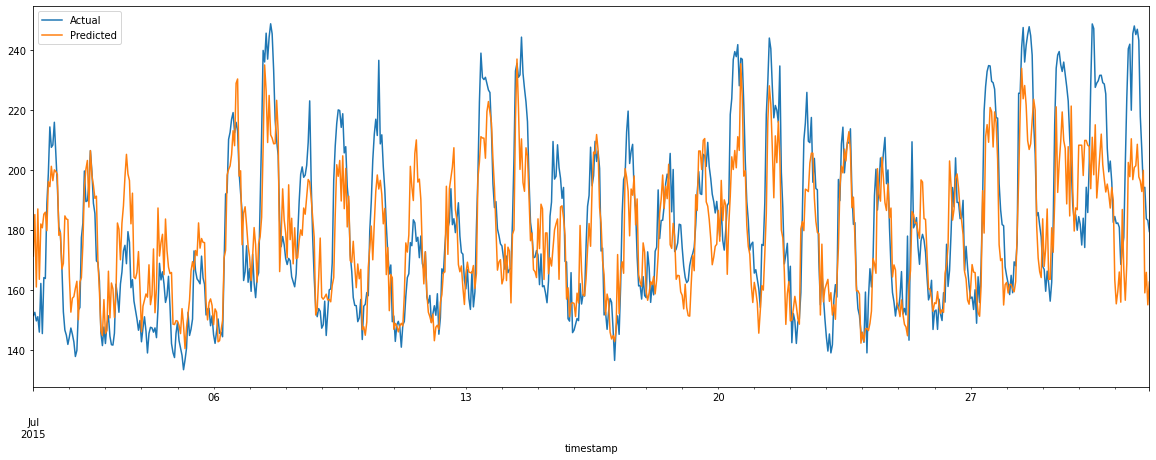

In [75]:
predicted_vs_actual.plot()

In [76]:
trainingdata.columns = ["Actual"]

In [77]:
predicted_vs_actual_plus_training = pd.concat([trainingdata, predicted_vs_actual], sort=True)

<AxesSubplot:xlabel='timestamp'>

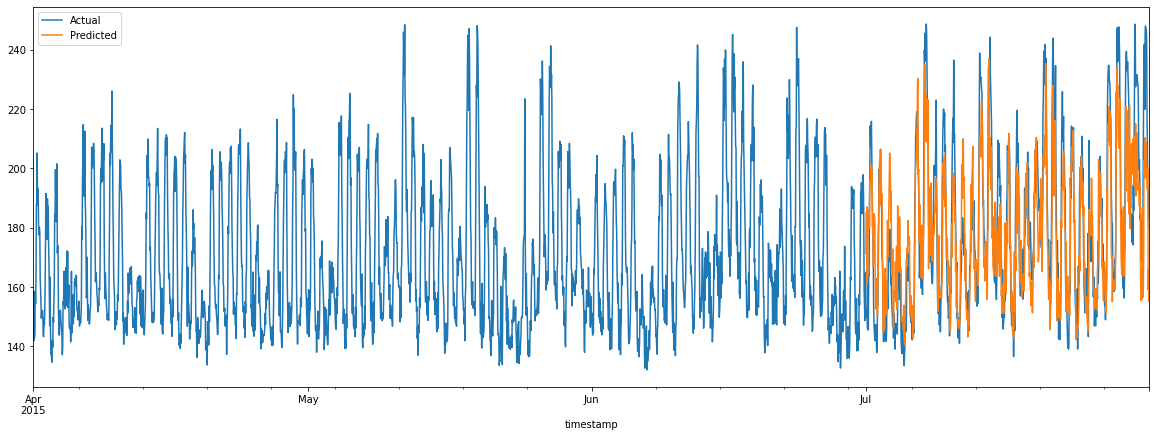

In [78]:
predicted_vs_actual_plus_training.plot()

### Regression Evaluation Metrix

In [79]:
# Calculate the absolute errors
errors = abs(predicted_vs_actual['Predicted'] - predicted_vs_actual['Actual'])
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / predicted_vs_actual['Actual']))

In [80]:
#MEAN ABSOLUTE PERCENTAGE ERROR
MAPE

6.959883250592195

In [81]:
### END ###